# Stage 1

- has **`location_raw`**: False
- vars one-hot encoded: True
- var label-encoded: False
- oversampled: False

In [1]:
import pickle

import humanize
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.externals.joblib import parallel_backend
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split


%matplotlib inline
%load_ext autoreload

In [2]:
X_train = pickle.load(open('./data/stage6-train.pkl', 'rb'))
y_train = X_train.pop('stop_outcome')
X_test = pickle.load(open('./data/stage6-test.pkl', 'rb'))
y_test = X_test.pop('stop_outcome')

print('Row counts:\n\ttrain: {}\n\ttest: {}'.format(X_train.shape[0], X_test.shape[0]))


Row counts:
	train: 250131
	test: 62533


In [3]:
# Split the 'features' and 'labels' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features,
#                                                     labels, 
#                                                     test_size=0.2, 
#                                                     random_state=0)
# final_test_features = pickle.load(open('./data/final_test_set.pkl', 'rb'))
# final_test_outcomes = final_test_features.pop('stop_outcome')
# print('Final test set row count: {}'.format(final_test_features.shape[0]))

# X_train = features
# y_train = labels
# X_test = final_test_features
# y_test = final_test_outcomes

# Benchmark

In [4]:
predictions = [2]
accuracy_score(y_test, predictions * y_test.shape[0])

0.69125101946172418

# Simple Linear Classifier

In [5]:
from sklearn import linear_model

clf_sgd = linear_model.SGDClassifier()
clf_sgd.fit(X_train, y_train)
clf_sgd.score(X_test, y_test)

/home/pato/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.69374570226920185

# VotingClassifier

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# clf1 = RandomForestClassifier(n_jobs=8, verbose=3, random_state=0)
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(random_state=0)
# clf4 = GradientBoostingClassifier(verbose=3, random_state=0)

eclf = VotingClassifier(estimators=[
#                                     ('rf', clf1),
                                    ('gnb', clf2),
                                    ('dt', clf3),
#                                     ('gb', clf4)
                                   ], voting='soft')
eclf = eclf.fit(X_train, y_train)
print('eclf score: {}'.format(eclf.score(X_test, y_test)))

eclf score: 0.5561703420593926


In [7]:
eclf.estimators_

[GaussianNB(priors=None),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best')]

# RandomForestClassifier

In [8]:
rfc = RandomForestClassifier(n_jobs=8, verbose=3, random_state=0)
rfc.fit(X_train, y_train)
print('{}'.format(rfc.score(X_test, y_test)))

building tree 2 of 10
building tree 3 of 10building tree 5 of 10building tree 6 of 10building tree 1 of 10building tree 7 of 10building tree 4 of 10





building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s


0.6995186541506084


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


# GradientBoostingClassifier

In [9]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)
print('{}'.format(gbc.score(X_test, y_test)))

0.7199718548606335


## GradientBoostingClassifier (Tuned)


In [10]:
gbc_tuned = GradientBoostingClassifier(
    learning_rate=0.0983,
    max_depth=6,
#     max_depth=9,
    max_features=len(list(X_train.columns.values)),
    subsample=0.9,
    verbose=3,
    random_state=0,
)
gbc_tuned.fit(X_train, y_train)
print('{}'.format(gbc_tuned.score(X_test, y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      275431.5227        2403.6603            3.96m
         2      258564.9943        1880.8472            3.90m
         3      244993.9534        1488.8967            3.85m
         4      233980.4180        1236.2195            3.80m
         5      224674.9008        1017.5219            3.79m
         6      217231.6770         797.8777            3.74m
         7      210869.0884         700.8846            3.72m
         8      205708.7714         542.1076            3.69m
         9      201339.8812         473.1935            3.65m
        10      197804.2383         407.9366            3.62m
        11      194474.7335         343.5645            3.59m
        12      191923.0222         277.6174            3.57m
        13      189387.3880         262.7271            3.56m
        14      187102.1279         222.3698            3.53m
        15      185623.9048         174.1965            3.49m
       

In [11]:
headers = ['Arrest', 'Summons', 'Ticket', 'Verbal Warning', 'Written Warning']
cm = pd.DataFrame(data=confusion_matrix(y_test, gbc_tuned.predict(X_test)), columns=headers, index=headers)
cm

,Arrest,Summons,Ticket,Verbal Warning,Written Warning
Arrest,520,122,700,55,9
Summons,182,665,1714,78,18
Ticket,294,193,41004,1411,324
Verbal Warning,22,37,5892,2552,240
Written Warning,23,11,4421,1305,741


In [12]:
precision_recall_fscore_support(y_test, gbc_tuned.predict(X_test), average=None)

(array([ 0.49951969,  0.64688716,  0.76313488,  0.47250509,  0.55630631]),
 array([ 0.36984353,  0.25028227,  0.94859575,  0.29189066,  0.11398246]),
 array([ 0.42501022,  0.36092266,  0.84581825,  0.36085973,  0.18919954]),
 array([ 1406,  2657, 43226,  8743,  6501]))

In [13]:
precision_recall_fscore_support(y_test, gbc_tuned.predict(X_test), average='micro')

(0.72732797083140099, 0.72732797083140099, 0.72732797083140099, None)

In [14]:
precision_recall_fscore_support(y_test, gbc_tuned.predict(X_test), average='macro')

(0.5876706251352537, 0.39491893463056255, 0.43636207885233008, None)

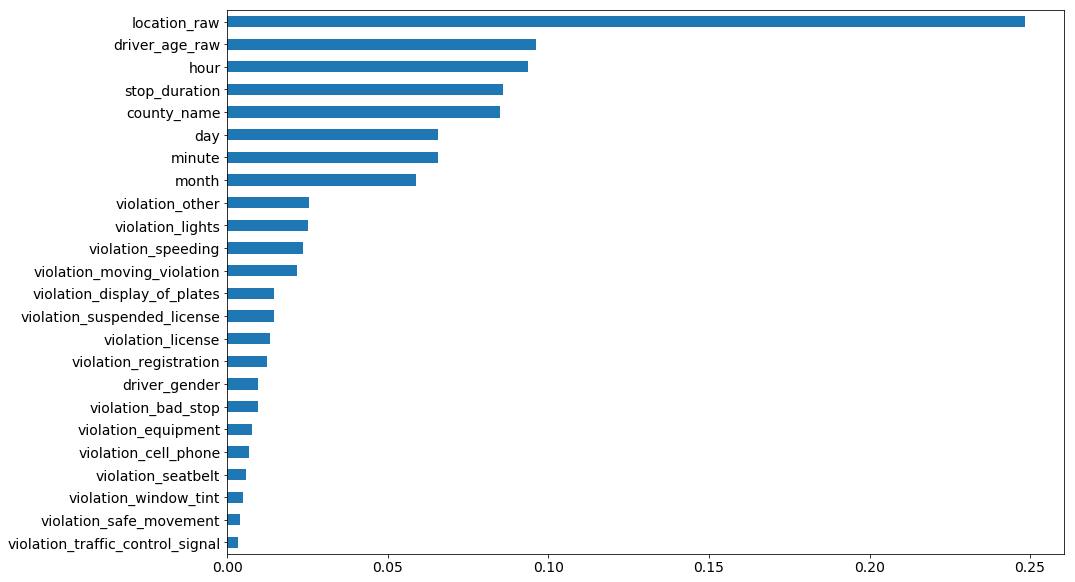

In [15]:
gbc_tuned_df = pd.DataFrame(data=gbc_tuned.feature_importances_, index=X_train.columns.values)
gbc_tuned_plot = gbc_tuned_df.sort_values(by=0).plot.barh(figsize=(15, 10), fontsize=14)
gbc_tuned_plot.axes.legend().set_visible(False)